# Sphere Optimization Demo - RiemannAX


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import riemannax as rx

In [2]:
def plot_sphere_with_points(points, colors=None, labels=None):
    """Function to plot a 3D sphere with points on its surface from multiple viewpoints"""
    fig = plt.figure(figsize=(15, 10))

    # Create viewpoints - different angles to view the sphere
    viewpoints = [
        (30, 45),  # Standard perspective view
        (90, 0),  # Side view
        (0, 0),  # Front view
        (0, 90),  # Top view
    ]

    for i, (elev, azim) in enumerate(viewpoints):
        ax = fig.add_subplot(2, 2, i + 1, projection="3d")

        # Plot the sphere with higher transparency
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))

        ax.plot_surface(x, y, z, color="skyblue", alpha=0.2)  # More transparent

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(f"View: elevation={elev}°, azimuth={azim}°")

        # Plot the North Pole
        ax.scatter([0], [0], [1], color="red", s=100, label="North Pole (Target)")

        # Plot optimization points with small offsets if too close to each other
        if colors is None:
            colors = ["blue"] * len(points)

        for j, point in enumerate(points):
            label = labels[j] if labels is not None and j < len(labels) else None

            # Add a small offset to the optimal solution to avoid overlap
            # Only if it's very close to the target (North Pole)
            plot_point = point.copy()
            if j == 1 and np.linalg.norm(point - np.array([0, 0, 1])) < 0.05:
                # Add small offset for visualization purposes only
                plot_point = plot_point * 0.98  # Slightly scale down to avoid overlap

            ax.scatter(
                plot_point[0],
                plot_point[1],
                plot_point[2],
                color=colors[j],
                s=100,
                label=label,
                edgecolor="white",
            )

        # Show legend
        ax.legend()

        # Set viewpoint
        ax.view_init(elev=elev, azim=azim)

        # Make grid lines more visible
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

Initial point: [-0.0511299  0.8438342  0.5341624]
Optimal point: [-1.7969418e-06  2.9656241e-05  9.9999988e-01]
Cost function value: -0.9999998807907104
Number of iterations until convergence: 100


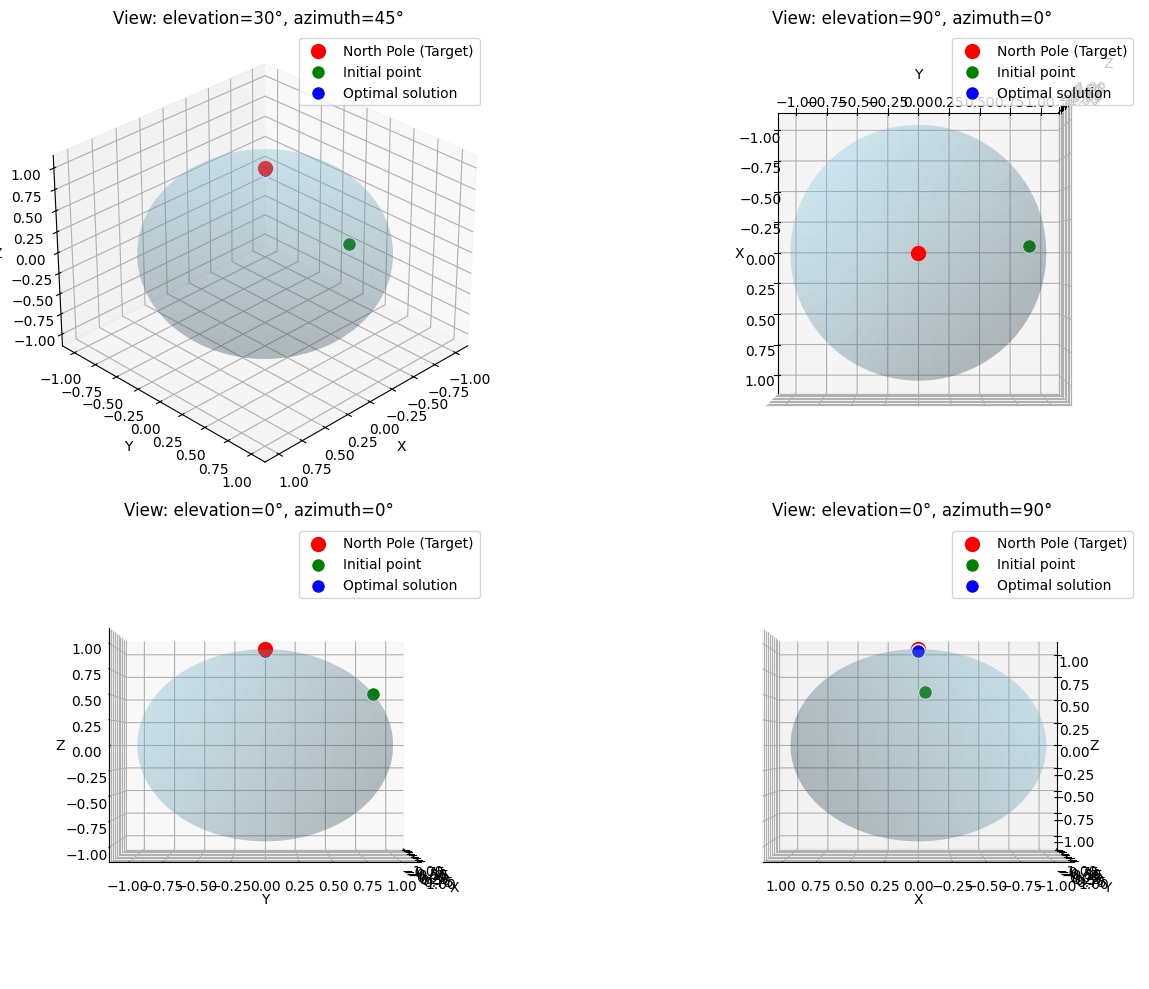

In [3]:
# 1. Define the sphere manifold
sphere = rx.Sphere()

# 2. Define the optimization problem - Find point closest to North Pole [0, 0, 1]
def cost_fn(x):
    target = jnp.array([0.0, 0.0, 1.0])  # North Pole
    return -jnp.dot(x, target)  # Maximize inner product (equivalent to minimizing distance)

problem = rx.RiemannianProblem(sphere, cost_fn)

# 3. Set a random initial point
key = jax.random.PRNGKey(42)
x0 = sphere.random_point(key)

# 4. Solve the problem
result = rx.minimize(
    problem, x0, method="rsgd", options={"learning_rate": 0.1, "max_iterations": 100}
)

# 5. Display results
print(f"Initial point: {x0}")
print(f"Optimal point: {result.x}")
print(f"Cost function value: {result.fun}")
print(f"Number of iterations until convergence: {result.niter}")

# 6. Visualization
fig = plot_sphere_with_points(
    [x0, result.x], colors=["green", "blue"], labels=["Initial point", "Optimal solution"]
)
plt.savefig("output/sphere_optimization.png")
plt.show()